## Import Libraries

In [ ]:
#!pip -q install torch==2.6.0 wordCloud ipywidgets textstat==0.7.10 pyarrow transformers datasets accelerate evaluate scikit-learn==1.6.0 

In [2]:
# ===============================
# Imports
# ===============================
import os, re, math, json, random, time, unicodedata
from urllib.parse import urljoin

import numpy as np
import seaborn as sns
import warnings
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from textstat import flesch_reading_ease
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, confusion_matrix
)

import datasets
from datasets import Dataset, DatasetDict
import evaluate

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)

2025-10-02 12:25:44.184921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759407944.381825      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759407944.438123      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# ===============================
# Config
# ===============================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Paths
CSV_PATH = "/kaggle/input/hoaxdetectionwithindonesiannews/600 news with valid hoax label.csv"
TEXT_COL = "berita"
LABEL_COL = "tagging"

# Pretrained models (Indonesian & multilingual)
id_models = [
    "indobenchmark/indobert-base-p1",        # IndoBERT
    "distilbert-base-multilingual-cased",    # DistilBERT (multilingual)
    "bert-base-multilingual-uncased",        # mBERT
]

# ===============================
# Explore Input Files
# ===============================
print("\nAvailable input files:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Device: cuda

Available input files:
/kaggle/input/hoaxdetectionwithindonesiannews/600 news with valid hoax label.csv


## Data Loading

In [4]:
df = pd.read_csv(CSV_PATH, encoding="latin1", sep=None, engine="python")
assert TEXT_COL in df.columns and LABEL_COL in df.columns, f"Kolom {TEXT_COL} dan {LABEL_COL} harus ada di CSV!"

print("=== SHAPE ===")
print(df.shape)
print("\n=== DTYPES ===")
print(df.dtypes)
print("\n=== MISSING VALUES ===")
print(df.isna().sum())

print("\n=== SAMPLE ROWS ===")
display(df.head())

print("\n=== CLASS DISTRIBUTION ===")
print(df[LABEL_COL].value_counts(dropna=False))

=== SHAPE ===
(600, 2)

=== DTYPES ===
berita     object
tagging    object
dtype: object

=== MISSING VALUES ===
berita     0
tagging    0
dtype: int64

=== SAMPLE ROWS ===


,berita,tagging
0,"Jakarta, Di jejaring sosial, banyak beredar in...",Valid
1,Isu bahwa ikan lele mengandung sel kanker di j...,Valid
2,Bagi penikmat kuliner dengan bahan dasar ikan ...,Valid
3,Ikan lele merupakan salah satu makanan favorit...,Valid
4,Ikan lele merupakan bahan makanan yang cukup p...,Valid



=== CLASS DISTRIBUTION ===
tagging
Valid    372
Hoax     228
Name: count, dtype: int64


## Exploratory Data Analysis

In [5]:
df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)

# Optional: minimal cleaning
def clean_text(s: str):
    if not isinstance(s, str):
        return ""
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

df[TEXT_COL] = df[TEXT_COL].astype(str).map(clean_text)
df = df[df[TEXT_COL].str.len() > 0].reset_index(drop=True)
print("Final rows after cleaning:", len(df))

Final rows after cleaning: 600


In [ ]:
def text_stats(series: pd.Series):
    s = series.astype(str)
    feats = pd.DataFrame({
        "char_len": s.str.len(),
        "word_count": s.str.split().map(len),
        "digit_count": s.str.count(r"\d"),
        "upper_count": s.str.count(r"[A-Z]"),
        "punct_count": s.str.count(r"[^\w\s]")
    }, index=s.index)
    # average word length
    clean = s.str.replace(r"[^A-Za-z0-9\s]", "", regex=True).str.split()
    feats["avg_word_len"] = clean.map(lambda words: np.mean([len(w) for w in words]) if len(words)>0 else 0.0)
    feats["unique_char"] = s.map(lambda x: len(set(list(x))))
    return feats

stats_df = text_stats(df[TEXT_COL])
display(stats_df.describe().T)

### Tampilkan info dasar dataset

In [7]:
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (600, 2)

Column Names:
['berita', 'tagging']

First 5 rows:


,berita,tagging
0,"Jakarta, Di jejaring sosial, banyak beredar in...",Valid
1,Isu bahwa ikan lele mengandung sel kanker di j...,Valid
2,Bagi penikmat kuliner dengan bahan dasar ikan ...,Valid
3,Ikan lele merupakan salah satu makanan favorit...,Valid
4,Ikan lele merupakan bahan makanan yang cukup p...,Valid


### Analisis Loading Data
- Dataset berhasil dimuat dengan struktur yang sesuai
- Terdapat 2 kolom utama: `berita` (teks berita) dan `tagging` (label)
- Perlu dilakukan pengecekan missing values dan duplikasi data

### 2. Basic Dataset Information

In [8]:
# Informasi dasar dataset
print("=== DATASET INFORMATION ===")
print(f"Total samples: {len(df)}")
print(f"Total features: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

print("\n=== DATA TYPES ===")
print(df.dtypes)

print("\n=== MISSING VALUES ===")
missing_data = df.isnull().sum()
print(missing_data)
print(f"\nPercentage missing data:")
for col in df.columns:
    missing_pct = (df[col].isnull().sum() / len(df)) * 100
    print(f"{col}: {missing_pct:.2f}%")

=== DATASET INFORMATION ===
Total samples: 600
Total features: 2
Memory usage: 0.01 MB

=== DATA TYPES ===
berita     object
tagging    object
dtype: object

=== MISSING VALUES ===
berita     0
tagging    0
dtype: int64

Percentage missing data:
berita: 0.00%
tagging: 0.00%


In [9]:
# Cek duplikasi data
print("=== DUPLICATE DATA ===")
duplicate_count = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")
print(f"Percentage duplicates: {(duplicate_count/len(df))*100:.2f}%")

# Cek duplikasi pada kolom berita saja
text_duplicates = df['berita'].duplicated().sum()
print(f"\nDuplicate news content: {text_duplicates}")
print(f"Percentage duplicate content: {(text_duplicates/len(df))*100:.2f}%")

=== DUPLICATE DATA ===
Total duplicate rows: 0
Percentage duplicates: 0.00%

Duplicate news content: 0
Percentage duplicate content: 0.00%


### Analisis Data Quality
- **Missing Values**: Mengidentifikasi kolom dengan data kosong yang perlu di-handle
- **Duplicates**: Data duplikat dapat mempengaruhi performance model dan perlu dipertimbangkan untuk dihapus
- **Data Types**: Memastikan tipe data sesuai untuk text processing

### 3. Target Variable Analysis

=== TARGET DISTRIBUTION ===
tagging
Valid    372
Hoax     228
Name: count, dtype: int64

Percentage distribution:
tagging
Valid    62.0
Hoax     38.0
Name: proportion, dtype: float64


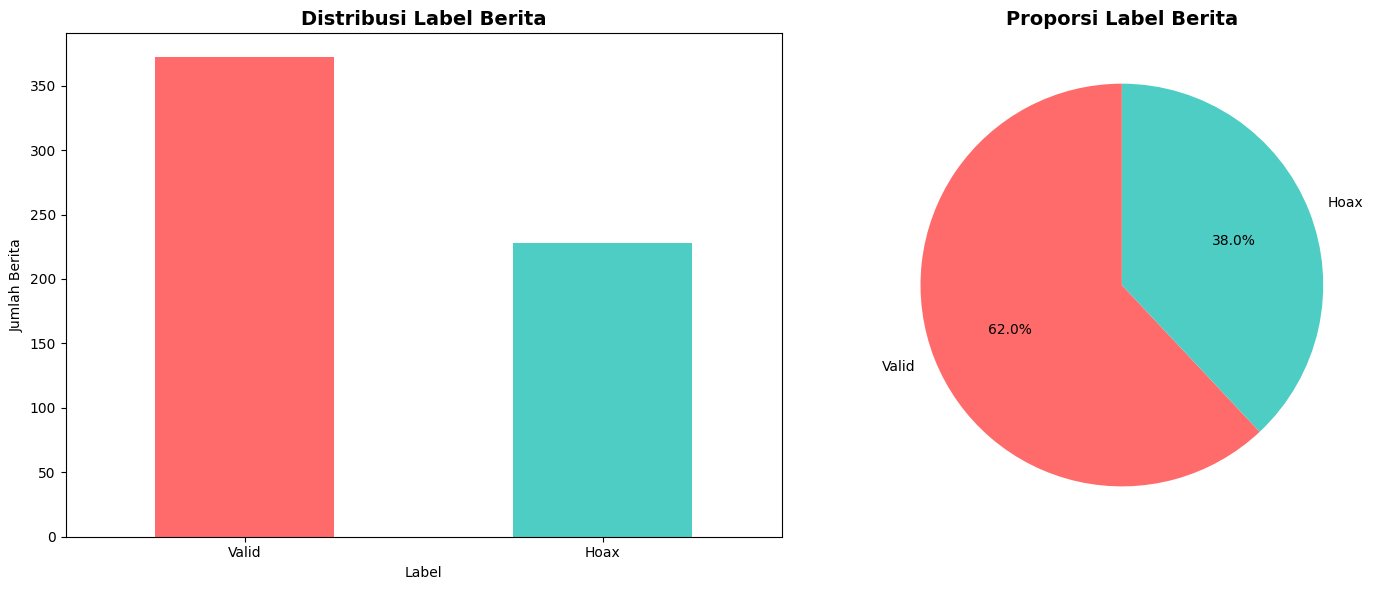


Class imbalance ratio: 0.613
⚠️  Dataset memiliki class imbalance yang signifikan


In [10]:
# Analisis distribusi label
print("=== TARGET DISTRIBUTION ===")
label_counts = df['tagging'].value_counts()
print(label_counts)
print(f"\nPercentage distribution:")
label_pct = df['tagging'].value_counts(normalize=True) * 100
print(label_pct)

# Visualisasi distribusi label
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
label_counts.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Distribusi Label Berita', fontsize=14, fontweight='bold')
ax1.set_xlabel('Label')
ax1.set_ylabel('Jumlah Berita')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
ax2.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
        colors=['#FF6B6B', '#4ECDC4'], startangle=90)
ax2.set_title('Proporsi Label Berita', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Cek class imbalance
imbalance_ratio = label_counts.min() / label_counts.max()
print(f"\nClass imbalance ratio: {imbalance_ratio:.3f}")
if imbalance_ratio < 0.8:
    print("⚠️  Dataset memiliki class imbalance yang signifikan")
else:
    print("✅ Dataset relatif seimbang")

### Analisis Target Variable
- **Class Distribution**: Menunjukkan proporsi berita Valid vs Hoax dalam dataset
- **Class Imbalance**: Rasio ketidakseimbangan kelas yang dapat mempengaruhi performa model
- **Handling Strategy**: Jika terdapat imbalance signifikan, pertimbangkan teknik sampling atau cost-sensitive learning

### Handling Imbalance Data

In [12]:
# ===============================
# CONFIG
# ===============================
BASE_HOAX = "https://turnbackhoax.id/"
BASE_VALID = "https://nasional.sindonews.com/more/5"
HEADERS = {"User-Agent": "Mozilla/5.0"}
MAX_RETRIES = 5
TARGET_VALID = 550
TARGET_HOAX = 550

# ===============================
# Helpers
# ===============================
def fetch_soup(url):
    r = requests.get(url, headers=HEADERS, timeout=20)
    r.raise_for_status()
    return BeautifulSoup(r.text, "html.parser")

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return None
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r"[^A-Za-z0-9.,!?()/%:;\-\s]", " ", text)
    text = re.sub(r"(?<=\s)[a-zA-Z](?=\s)", " ", text)
    text = re.sub(r"[.!?]{2,}", lambda m: m.group(0)[0], text)
    text = re.sub(r"\s+", " ", text).strip()
    return text if len(text) >= 5 else None

def get_needed_counts(df):
    current_valid = df[df["tagging"] == "Valid"].shape[0]
    current_hoax = df[df["tagging"] == "Hoax"].shape[0]
    needed_valid = max(0, TARGET_VALID - current_valid)
    needed_hoax = max(0, TARGET_HOAX - current_hoax)
    return needed_valid, needed_hoax

# ===============================
# Hoax Scraper
# ===============================
def extract_article_text(url):
    for attempt in range(MAX_RETRIES):
        try:
            soup = fetch_soup(url)
            blockquote = soup.find("blockquote")
            if blockquote:
                texts = [p.get_text(strip=True) for p in blockquote.find_all("p")]
                if texts:
                    return clean_text(" ".join(texts))
            return None
        except Exception:
            time.sleep(1)
    return None

def scrape_hoax(n_items, existing_urls=None):
    if existing_urls is None:
        existing_urls = set()

    collected, seen, page = [], set(), 1
    while len(collected) < n_items:
        url = BASE_HOAX if page == 1 else f"{BASE_HOAX}page/{page}/"
        try:
            soup = fetch_soup(url)
        except Exception:
            page += 1
            continue

        articles = soup.select("div#main-content article.mh-loop-item")
        if not articles:
            break

        for article in articles:
            if len(collected) >= n_items:
                break

            link_tag = article.select_one("h3.entry-title a")
            if not link_tag:
                continue

            article_url = link_tag.get("href")
            if not article_url or article_url in seen or article_url in existing_urls:
                continue
            seen.add(article_url)

            text = extract_article_text(article_url)
            if text:
                collected.append({"berita": text, "tagging": "Hoax", "url": article_url})
                existing_urls.add(article_url)

            time.sleep(0.2)

        page += 1

    return pd.DataFrame(collected)

# ===============================
# Sindonews Valid Scraper
# ===============================
def extract_first_paragraph(url):
    for attempt in range(MAX_RETRIES):
        try:
            soup = fetch_soup(url)
            detail = soup.find("div", id="detail-desc")
            if detail:
                first_p = detail.get_text(separator="\n", strip=True).split("\n")[0]
                if "–" in first_p:
                    first_p = first_p.split("–", 1)[1].strip()
                return clean_text(first_p)
        except Exception:
            time.sleep(1)
    return None

def scrape_valid(n_items, existing_urls=None):
    if existing_urls is None:
        existing_urls = set()

    collected, page_url, failed_urls = [], BASE_VALID, []
    while len(collected) < n_items:
        if not page_url and not failed_urls:
            break  # nothing left to try

        if failed_urls:
            url = failed_urls.pop(0)  # retry failed URL
            text = extract_first_paragraph(url)
            if text:
                collected.append({"berita": text, "tagging": "Valid", "url": url})
                existing_urls.add(url)
            continue

        try:
            soup = fetch_soup(page_url)
        except Exception:
            page_url = None
            continue

        articles = soup.find_all("div", class_="warp-article")
        for a in articles:
            link_tag = a.find("div", class_="warp-title-article").find("div", class_="title-article")
            if link_tag:
                link = link_tag.find_parent("a")
                if link:
                    url = link.get("href")
                    if not url or url in existing_urls:
                        continue
                    text = extract_first_paragraph(url)
                    if text:
                        collected.append({"berita": text, "tagging": "Valid", "url": url})
                        existing_urls.add(url)
                    else:
                        failed_urls.append(url)
            if len(collected) >= n_items:
                break

        next_btn = soup.find("a", rel="next")
        page_url = urljoin(BASE_VALID, next_btn["href"]) if next_btn else None
        time.sleep(0.2)

    return pd.DataFrame(collected)

# ===============================
# Update Dataset
# ===============================
def update_dataset(df):
    existing_urls = set(df.get("url", []))
    needed_valid, needed_hoax = get_needed_counts(df)

    hoax_df = scrape_hoax(n_items=needed_hoax, existing_urls=existing_urls)
    valid_df = scrape_valid(n_items=needed_valid, existing_urls=existing_urls)

    print(f"Scraped {len(hoax_df)} Hoax samples, {len(valid_df)} Valid samples")

    df = pd.concat([df, hoax_df, valid_df], ignore_index=True)
    return df

In [13]:
# Update dataset
df = update_dataset(df)

# Show counts after update
print("\n🔎 Tagging counts after update:")
print(df['tagging'].value_counts())

Scraped 322 Hoax samples, 178 Valid samples

🔎 Tagging counts after update:
tagging
Valid    550
Hoax     550
Name: count, dtype: int64


In [14]:
duplicates = df[df.duplicated()]

# Print duplicate rows
print("Number of duplicate rows:", duplicates.shape[0])
print(duplicates)

Number of duplicate rows: 0
Empty DataFrame
Columns: [berita, tagging, url]
Index: []


### 4. Text Length Analysis

In [15]:
# Analisis panjang teks
df['text_length'] = df['berita'].str.len()
df['word_count'] = df['berita'].str.split().str.len()
df['sentence_count'] = df['berita'].str.split('.').str.len()

print("=== TEXT LENGTH STATISTICS ===")
print("Character Length:")
print(df.groupby('tagging')['text_length'].describe())

print("\nWord Count:")
print(df.groupby('tagging')['word_count'].describe())

print("\nSentence Count:")
print(df.groupby('tagging')['sentence_count'].describe())

=== TEXT LENGTH STATISTICS ===
Character Length:
         count         mean          std   min     25%     50%      75%  \
tagging                                                                   
Hoax     550.0  1109.598182  1357.407020  12.0  138.25   396.0  1768.25   
Valid    550.0  1434.705455  1347.504641   5.0    7.00  1339.5  2144.25   

            max  
tagging          
Hoax     8570.0  
Valid    9618.0  

Word Count:
         count        mean         std  min   25%    50%     75%     max
tagging                                                                 
Hoax     550.0  156.887273  192.043147  2.0  20.0   57.0  247.75  1245.0
Valid    550.0  200.483636  188.078150  1.0   1.0  188.5  299.50  1263.0

Sentence Count:
         count       mean        std  min  25%   50%   75%    max
tagging                                                          
Hoax     550.0   9.710909  12.263280  1.0  1.0   4.0  15.0   77.0
Valid    550.0  12.849091  13.216598  1.0  1.0  12.0  20.0

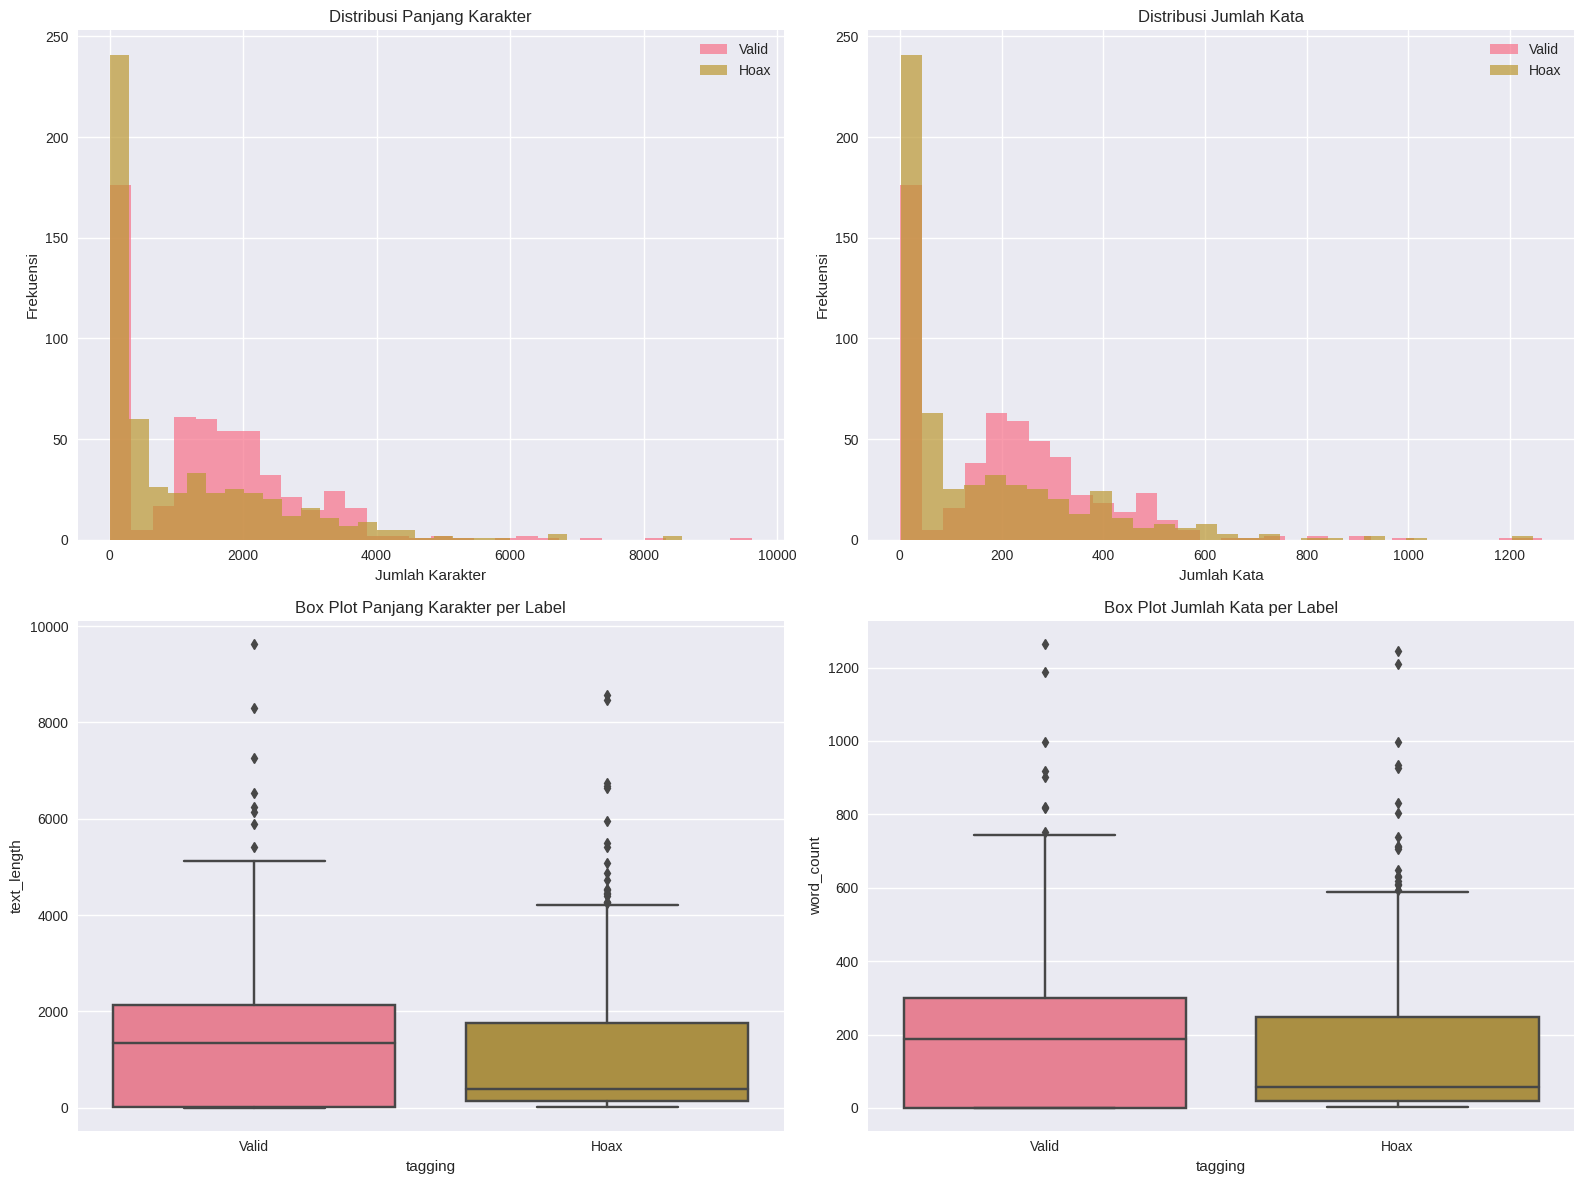

In [16]:
# Setting untuk visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
# Konfigurasi matplotlib untuk font Indonesia
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

# Visualisasi distribusi panjang teks
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Character length distribution
for label in df['tagging'].unique():
    data = df[df['tagging'] == label]['text_length']
    axes[0,0].hist(data, alpha=0.7, label=label, bins=30)
axes[0,0].set_title('Distribusi Panjang Karakter')
axes[0,0].set_xlabel('Jumlah Karakter')
axes[0,0].set_ylabel('Frekuensi')
axes[0,0].legend()

# Word count distribution
for label in df['tagging'].unique():
    data = df[df['tagging'] == label]['word_count']
    axes[0,1].hist(data, alpha=0.7, label=label, bins=30)
axes[0,1].set_title('Distribusi Jumlah Kata')
axes[0,1].set_xlabel('Jumlah Kata')
axes[0,1].set_ylabel('Frekuensi')
axes[0,1].legend()

# Box plot for character length
sns.boxplot(data=df, x='tagging', y='text_length', ax=axes[1,0])
axes[1,0].set_title('Box Plot Panjang Karakter per Label')

# Box plot for word count
sns.boxplot(data=df, x='tagging', y='word_count', ax=axes[1,1])
axes[1,1].set_title('Box Plot Jumlah Kata per Label')

plt.tight_layout()
plt.show()

### Analisis Panjang Teks
- **Character/Word Distribution**: Menunjukkan pola panjang teks antara berita Valid dan Hoax
- **Statistical Differences**: Perbedaan rata-rata panjang teks dapat menjadi feature yang berguna
- **Outliers**: Teks yang terlalu pendek atau panjang mungkin perlu penanganan khusus

### 5. Text Content Analysis

In [17]:
# Fungsi untuk text preprocessing
def basic_preprocessing(text):
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Preprocessing untuk analisis
df['cleaned_text'] = df['berita'].apply(basic_preprocessing)

# Analisis kata yang paling sering muncul
def get_top_words(texts, n=20):
    all_words = []
    for text in texts:
        all_words.extend(text.split())
    return Counter(all_words).most_common(n)

print("=== TOP WORDS ANALYSIS ===")
for label in df['tagging'].unique():
    print(f"\nTop 15 words in {label} news:")
    label_texts = df[df['tagging'] == label]['cleaned_text']
    top_words = get_top_words(label_texts, 15)
    for word, count in top_words:
        print(f"{word}: {count}")

=== TOP WORDS ANALYSIS ===

Top 15 words in Valid news:
yang: 3472
dan: 2254
di: 2194
ini: 1161
dari: 1145
itu: 1142
tidak: 1108
tersebut: 988
dengan: 908
dalam: 871
ada: 807
untuk: 796
pada: 710
lele: 599
bahwa: 556

Top 15 words in Hoax news:
yang: 2567
dan: 1705
di: 1647
ini: 928
dari: 924
dengan: 775
tidak: 732
untuk: 716
itu: 699
dalam: 679
tersebut: 644
lele: 482
ada: 482
ikan: 467
juga: 443


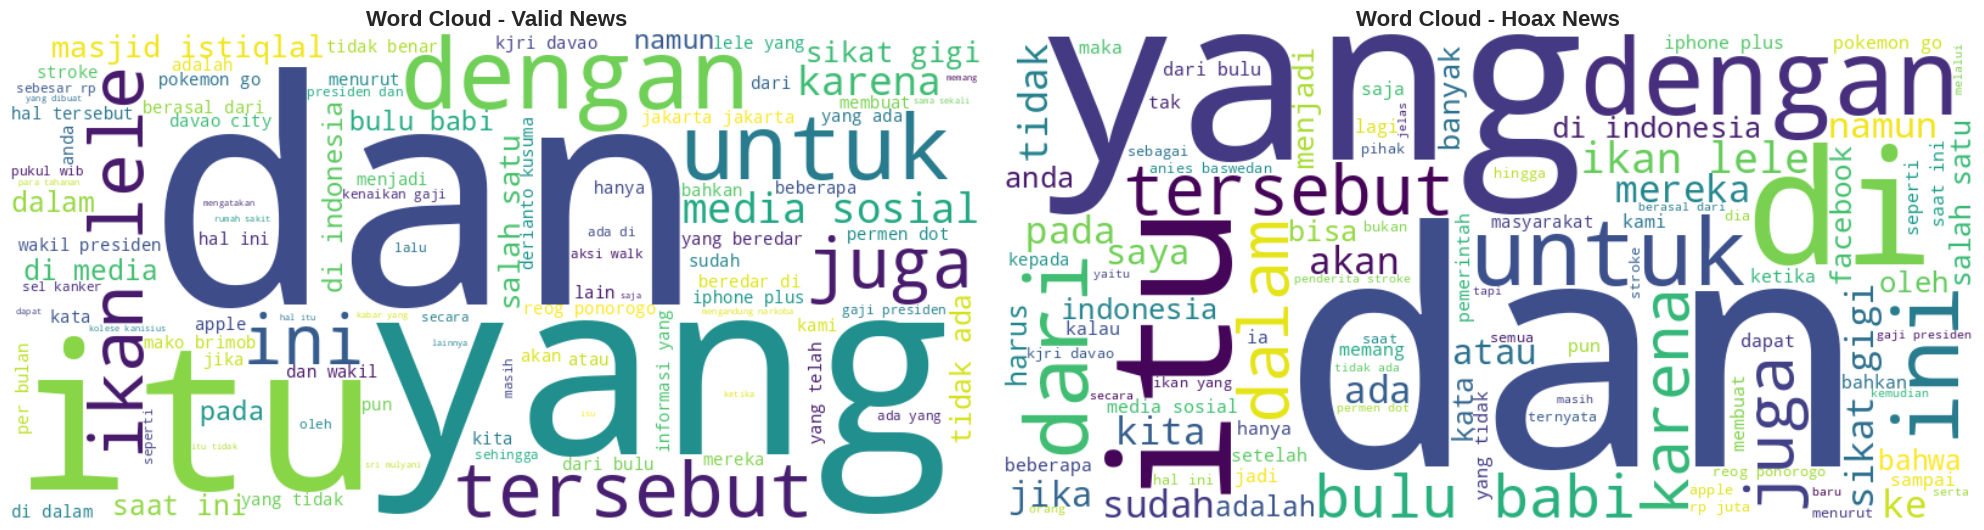

In [18]:
# Word Cloud untuk setiap label
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for idx, label in enumerate(df['tagging'].unique()):
    label_texts = df[df['tagging'] == label]['cleaned_text']
    text_combined = ' '.join(label_texts)

    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100,
                         colormap='viridis').generate(text_combined)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud - {label} News', fontsize=16, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Analisis Konten Teks
- **Top Words**: Identifikasi kata-kata yang paling sering muncul di setiap kategori
- **Word Cloud**: Visualisasi kata-kata dominan membantu memahami tema utama
- **Distinctive Features**: Kata-kata unik untuk setiap kategori dapat menjadi feature penting untuk klasifikasi

### 6. Advanced Text Features Analysis

In [19]:
# Analisis fitur teks lanjutan
def extract_text_features(text):
    features = {}

    # Basic counts
    features['char_count'] = len(text)
    features['word_count'] = len(text.split())
    features['sentence_count'] = len(text.split('.'))

    # Punctuation analysis
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['uppercase_count'] = sum(1 for c in text if c.isupper())

    # Number analysis
    features['number_count'] = len(re.findall(r'\d+', text))

    # Average word length
    words = text.split()
    if words:
        features['avg_word_length'] = np.mean([len(word) for word in words])
    else:
        features['avg_word_length'] = 0

    return features

# Extract features untuk semua teks
text_features = df['berita'].apply(extract_text_features)
feature_df = pd.DataFrame(list(text_features))
feature_df['tagging'] = df['tagging']

# Statistik fitur per label
print("=== ADVANCED TEXT FEATURES ===")
for feature in ['exclamation_count', 'question_count', 'uppercase_count', 'number_count', 'avg_word_length']:
    print(f"\n{feature.upper()}:")
    print(feature_df.groupby('tagging')[feature].describe())

=== ADVANCED TEXT FEATURES ===

EXCLAMATION_COUNT:
         count      mean       std  min  25%  50%  75%   max
tagging                                                     
Hoax     550.0  0.221818  0.794950  0.0  0.0  0.0  0.0  11.0
Valid    550.0  0.029091  0.223951  0.0  0.0  0.0  0.0   4.0

QUESTION_COUNT:
         count      mean       std  min  25%  50%  75%   max
tagging                                                     
Hoax     550.0  0.343636  1.223668  0.0  0.0  0.0  0.0  20.0
Valid    550.0  0.316364  0.983426  0.0  0.0  0.0  0.0   9.0

UPPERCASE_COUNT:
         count       mean        std  min   25%   50%   75%    max
tagging                                                           
Hoax     550.0  63.165455  79.494830  0.0  13.0  42.0  84.0  639.0
Valid    550.0  52.238182  47.035386  2.0   7.0  46.0  77.0  376.0

NUMBER_COUNT:
         count      mean       std  min  25%  50%  75%   max
tagging                                                     
Hoax     550.0  4.680

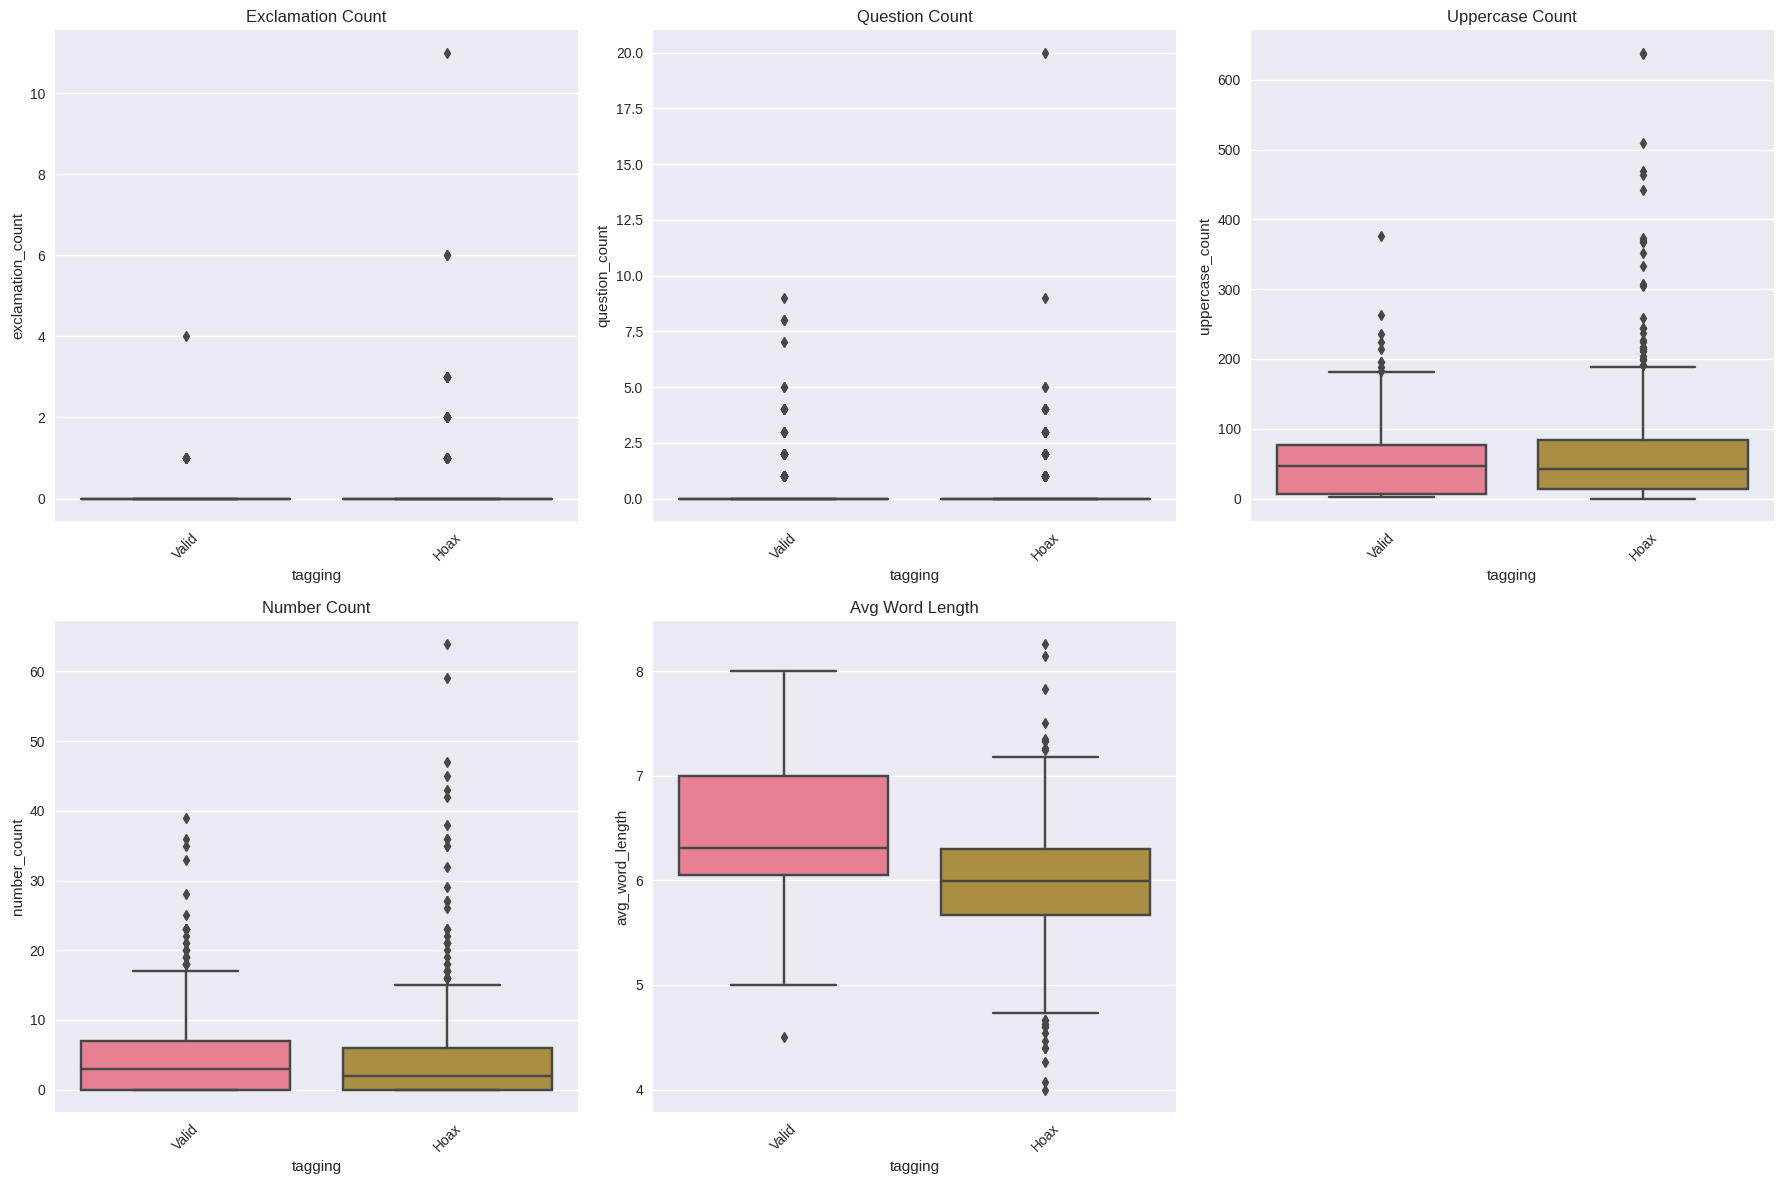

In [20]:
# Visualisasi fitur teks lanjutan
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

features_to_plot = ['exclamation_count', 'question_count', 'uppercase_count', 'number_count', 'avg_word_length']

for idx, feature in enumerate(features_to_plot):
    sns.boxplot(data=feature_df, x='tagging', y=feature, ax=axes[idx])
    axes[idx].set_title(f'{feature.replace("_", " ").title()}')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

### Analisis Fitur Teks Lanjutan
- **Punctuation Patterns**: Penggunaan tanda baca dapat mengindikasikan emotional tone
- **Uppercase Usage**: Banyaknya huruf kapital mungkin menunjukkan sensationalism
- **Number Usage**: Frekuensi angka dalam teks bisa menjadi indicator kredibilitas
- **Word Length**: Rata-rata panjang kata dapat menunjukkan kompleksitas bahasa

### 7. Keyword and Pattern Analysis

In [21]:
# Analisis keyword yang sering muncul di hoax
suspicious_keywords = [
    'viral', 'heboh', 'mengejutkan', 'menakjubkan', 'terungkap',
    'rahasia', 'fakta', 'sebenarnya', 'ternyata', 'breaking news',
    'waspada', 'hati hati', 'awas', 'jangan', 'bahaya'
]

# Hitung kemunculan keyword suspicious
def count_suspicious_words(text):
    text_lower = text.lower()
    count = 0
    found_words = []
    for keyword in suspicious_keywords:
        if keyword in text_lower:
            count += text_lower.count(keyword)
            found_words.append(keyword)
    return count, found_words

df['suspicious_word_count'] = df['berita'].apply(lambda x: count_suspicious_words(x)[0])
df['suspicious_words'] = df['berita'].apply(lambda x: count_suspicious_words(x)[1])

print("=== SUSPICIOUS KEYWORDS ANALYSIS ===")
print("Average suspicious word count per label:")
print(df.groupby('tagging')['suspicious_word_count'].mean())

print("\nDistribution of suspicious word counts:")
print(df.groupby('tagging')['suspicious_word_count'].describe())

=== SUSPICIOUS KEYWORDS ANALYSIS ===
Average suspicious word count per label:
tagging
Hoax     0.960000
Valid    1.050909
Name: suspicious_word_count, dtype: float64

Distribution of suspicious word counts:
         count      mean       std  min  25%  50%  75%   max
tagging                                                     
Hoax     550.0  0.960000  1.783919  0.0  0.0  0.0  1.0  13.0
Valid    550.0  1.050909  1.857675  0.0  0.0  0.0  1.0  12.0


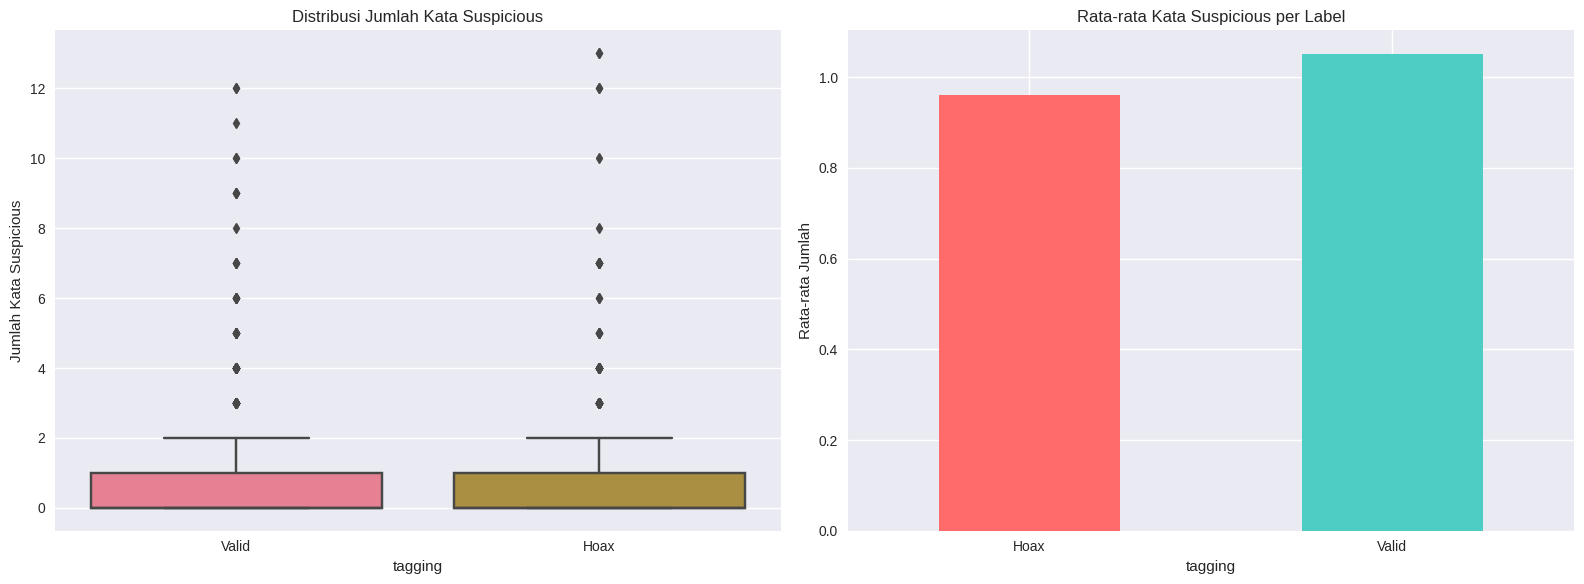


=== MOST FREQUENT SUSPICIOUS WORDS ===
Top 10 suspicious words found:
jangan: 129
bahaya: 115
ternyata: 111
sebenarnya: 77
viral: 76
waspada: 59
fakta: 51
awas: 46
heboh: 36
terungkap: 28


In [22]:
# Visualisasi suspicious keywords
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
sns.boxplot(data=df, x='tagging', y='suspicious_word_count', ax=axes[0])
axes[0].set_title('Distribusi Jumlah Kata Suspicious')
axes[0].set_ylabel('Jumlah Kata Suspicious')

# Bar plot rata-rata
suspicious_mean = df.groupby('tagging')['suspicious_word_count'].mean()
suspicious_mean.plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#4ECDC4'])
axes[1].set_title('Rata-rata Kata Suspicious per Label')
axes[1].set_ylabel('Rata-rata Jumlah')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Analisis kata-kata suspicious yang paling sering
print("\n=== MOST FREQUENT SUSPICIOUS WORDS ===")
all_suspicious = []
for words_list in df['suspicious_words']:
    all_suspicious.extend(words_list)

suspicious_counter = Counter(all_suspicious)
print("Top 10 suspicious words found:")
for word, count in suspicious_counter.most_common(10):
    print(f"{word}: {count}")

### Analisis Keyword dan Pola
- **Suspicious Keywords**: Kata-kata yang umumnya digunakan dalam clickbait atau hoax
- **Pattern Recognition**: Identifikasi pola linguistik yang membedakan berita valid dan hoax
- **Feature Engineering**: Hasil analisis ini dapat digunakan sebagai feature untuk model ML

### 8. Correlation Analysis

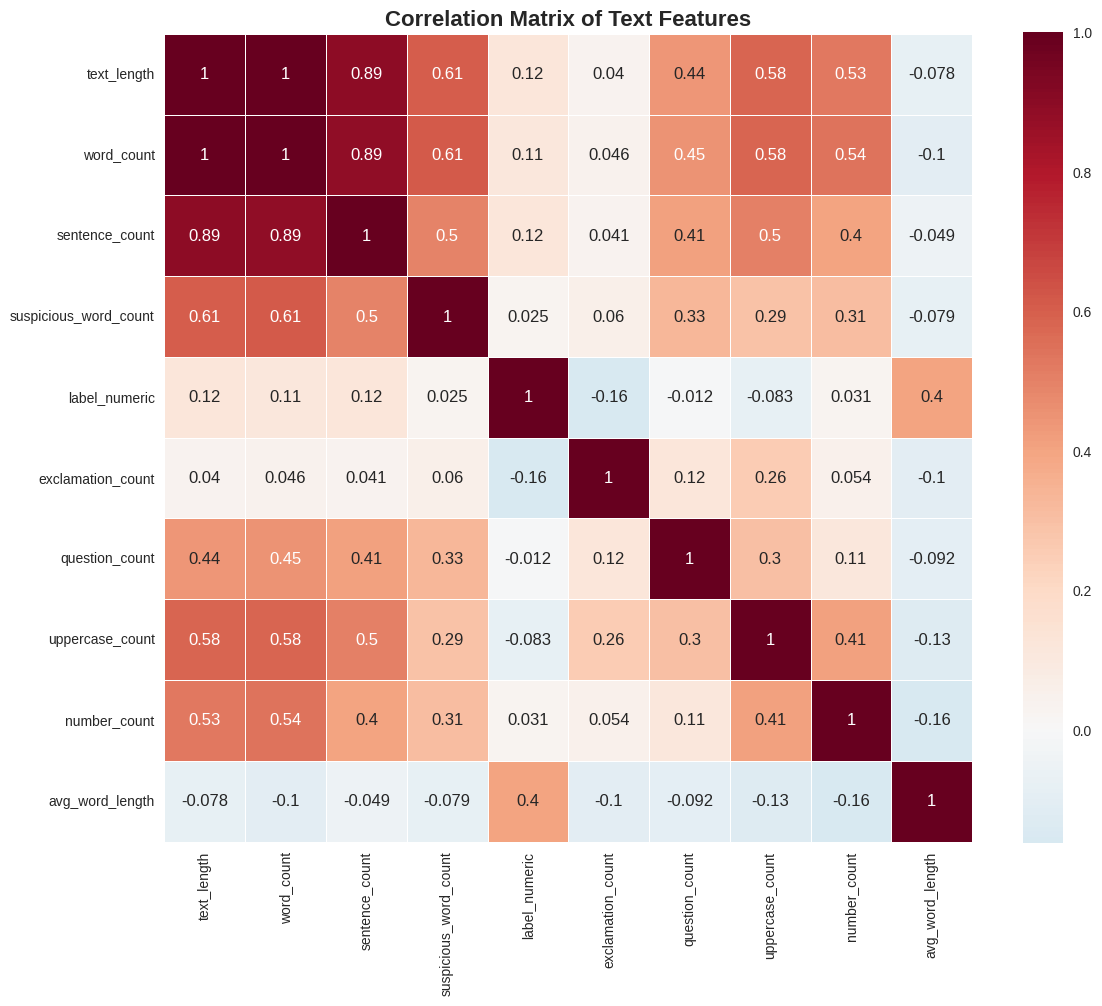

=== FEATURE CORRELATION WITH LABEL ===
Features ranked by absolute correlation with label:
avg_word_length: 0.4043
exclamation_count: 0.1630
sentence_count: 0.1223
text_length: 0.1194
word_count: 0.1140
uppercase_count: 0.0834
number_count: 0.0315
suspicious_word_count: 0.0250
question_count: 0.0123


In [23]:
# Membuat dataset untuk analisis korelasi
# Convert tagging ke numerik (0: Hoax, 1: Valid)
df['label_numeric'] = df['tagging'].map({'Hoax': 0, 'Valid': 1})

# Combine all numeric features
corr_features = [
    'text_length', 'word_count', 'sentence_count',
    'suspicious_word_count', 'label_numeric'
]

# Add features from feature_df
for feature in ['exclamation_count', 'question_count', 'uppercase_count', 'number_count', 'avg_word_length']:
    df[feature] = feature_df[feature]
    corr_features.append(feature)

# Correlation matrix
corr_matrix = df[corr_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Text Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance berdasarkan korelasi dengan label
feature_corr = corr_matrix['label_numeric'].abs().sort_values(ascending=False)
print("=== FEATURE CORRELATION WITH LABEL ===")
print("Features ranked by absolute correlation with label:")
for feature, corr in feature_corr.items():
    if feature != 'label_numeric':
        print(f"{feature}: {corr:.4f}")

### Analisis Korelasi
- **Feature Relationships**: Memahami hubungan antar fitur teks
- **Target Correlation**: Identifikasi fitur yang paling berkorelasi dengan label
- **Multicollinearity**: Deteksi fitur yang saling berkorelasi tinggi untuk feature selection

### 9. Sample Analysis

In [24]:
# Analisis sampel teks
print("=== SAMPLE TEXT ANALYSIS ===")

print("\n📰 CONTOH BERITA VALID:")
valid_samples = df[df['tagging'] == 'Valid']['berita'].head(3)
for i, text in enumerate(valid_samples, 1):
    print(f"\nSample {i}:")
    print(f"Length: {len(text)} characters")
    print(f"Text: {text[:200]}..." if len(text) > 200 else f"Text: {text}")

print("\n🚨 CONTOH BERITA HOAX:")
hoax_samples = df[df['tagging'] == 'Hoax']['berita'].head(3)
for i, text in enumerate(hoax_samples, 1):
    print(f"\nSample {i}:")
    print(f"Length: {len(text)} characters")
    print(f"Text: {text[:200]}..." if len(text) > 200 else f"Text: {text}")

=== SAMPLE TEXT ANALYSIS ===

📰 CONTOH BERITA VALID:

Sample 1:
Length: 1999 characters
Text: Jakarta, Di jejaring sosial, banyak beredar informasi yang menyebut lele sebagai ikan paling jorok. Dalam sesuap daging ikan lele, terkandung 3000 sel kanker. Benarkah? Julukan sebagai ikan paling jor...

Sample 2:
Length: 2858 characters
Text: Isu bahwa ikan lele mengandung sel kanker di jejaring social dan berita dari mulut ke mulut terus menyebar. Dampak dari isu tersebut para ibu ibu enggan membeli ikan lele. Waspada Online berhasil mera...

Sample 3:
Length: 1722 characters
Text: Bagi penikmat kuliner dengan bahan dasar ikan lele, berita ini sungguh sangat menyedihkan, bagaimana tidak, ikan yang selama ini sangat enak ini dianggap sebagai sumber penyakit . Beberapa informasi y...

🚨 CONTOH BERITA HOAX:

Sample 1:
Length: 3003 characters
Text: "Dalam sesuap daging ikan lele, terkandung 3.000 sel kanker". Judul artikel tersebut beberapa hari terakhir menjadi pembicaraan hangat di media sosi

### Analisis Sampel
- **Qualitative Analysis**: Pemahaman kualitatif tentang perbedaan gaya penulisan
- **Pattern Recognition**: Identifikasi pola manual yang mungkin terlewat dalam analisis kuantitatif
- **Domain Understanding**: Membangun intuisi untuk feature engineering dan model selection

### 10. Summary dan Insights

In [25]:
# Summary statistics
print("=== EDA SUMMARY ===")
print(f"📊 Dataset Size: {len(df):,} samples")
print(f"📈 Features Analyzed: {len(corr_features)} text features")
print(f"⚖️ Class Balance: {df['tagging'].value_counts().to_dict()}")

# Key findings
print("\n=== KEY FINDINGS ===")

# 1. Text length differences
valid_avg_length = df[df['tagging'] == 'Valid']['text_length'].mean()
hoax_avg_length = df[df['tagging'] == 'Hoax']['text_length'].mean()
print(f"\n1. 📝 TEXT LENGTH:")
print(f"   - Valid news average: {valid_avg_length:.0f} characters")
print(f"   - Hoax news average: {hoax_avg_length:.0f} characters")
print(f"   - Difference: {abs(valid_avg_length - hoax_avg_length):.0f} characters")

# 2. Suspicious words
valid_suspicious = df[df['tagging'] == 'Valid']['suspicious_word_count'].mean()
hoax_suspicious = df[df['tagging'] == 'Hoax']['suspicious_word_count'].mean()
print(f"\n2. 🚨 SUSPICIOUS KEYWORDS:")
print(f"   - Valid news average: {valid_suspicious:.2f} suspicious words")
print(f"   - Hoax news average: {hoax_suspicious:.2f} suspicious words")
print(f"   - Difference: {abs(valid_suspicious - hoax_suspicious):.2f}")

# 3. Top correlated features
print(f"\n3. 🎯 TOP FEATURES FOR CLASSIFICATION:")
top_features = feature_corr.head(4).index.tolist()
for feature in top_features:
    if feature != 'label_numeric':
        print(f"   - {feature}: {feature_corr[feature]:.4f} correlation")

print("\n=== RECOMMENDATIONS FOR MODELING ===")
print("\n🔧 PREPROCESSING:")
print("   - Handle missing values if any")
print("   - Remove or handle duplicate content")
print("   - Consider text normalization and cleaning")
print("   - Remove stop words for Indonesian language")

print("\n🎯 FEATURE ENGINEERING:")
print("   - Use TF-IDF or word embeddings for text representation")
print("   - Include text length and suspicious word count as features")
print("   - Consider punctuation and formatting patterns")
print("   - Extract named entities and sentiment scores")

print("\n🤖 MODEL SELECTION:")
print("   - Start with traditional ML: Naive Bayes, SVM, Random Forest")
print("   - Consider ensemble methods for better performance")
print("   - Explore deep learning: LSTM, BERT-based models")
print("   - Handle class imbalance if present")

print("\n📊 EVALUATION:")
print("   - Use stratified cross-validation")
print("   - Focus on precision and recall for both classes")
print("   - Consider F1-score and AUC-ROC")
print("   - Analyze misclassified samples for insights")

=== EDA SUMMARY ===
📊 Dataset Size: 1,100 samples
📈 Features Analyzed: 10 text features
⚖️ Class Balance: {'Valid': 550, 'Hoax': 550}

=== KEY FINDINGS ===

1. 📝 TEXT LENGTH:
   - Valid news average: 1435 characters
   - Hoax news average: 1110 characters
   - Difference: 325 characters

2. 🚨 SUSPICIOUS KEYWORDS:
   - Valid news average: 1.05 suspicious words
   - Hoax news average: 0.96 suspicious words
   - Difference: 0.09

3. 🎯 TOP FEATURES FOR CLASSIFICATION:
   - avg_word_length: 0.4043 correlation
   - exclamation_count: 0.1630 correlation
   - sentence_count: 0.1223 correlation

=== RECOMMENDATIONS FOR MODELING ===

🔧 PREPROCESSING:
   - Handle missing values if any
   - Remove or handle duplicate content
   - Consider text normalization and cleaning
   - Remove stop words for Indonesian language

🎯 FEATURE ENGINEERING:
   - Use TF-IDF or word embeddings for text representation
   - Include text length and suspicious word count as features
   - Consider punctuation and formatti

### 11. Advanced Linguistic Analysis

In [27]:
# Analisis linguistik lanjutan
import string
from collections import defaultdict

# Analisis penggunaan tanda baca
def analyze_punctuation(text):
    punct_counts = defaultdict(int)
    for char in text:
        if char in string.punctuation:
            punct_counts[char] += 1
    return dict(punct_counts)

# Analisis untuk setiap kategori
print("=== PUNCTUATION ANALYSIS ===")
for label in df['tagging'].unique():
    print(f"\n{label.upper()} NEWS PUNCTUATION PATTERNS:")
    label_texts = df[df['tagging'] == label]['berita']
    all_punct = defaultdict(int)

    for text in label_texts:
        punct_dict = analyze_punctuation(text)
        for punct, count in punct_dict.items():
            all_punct[punct] += count

    # Tampilkan 10 tanda baca terbanyak
    sorted_punct = sorted(all_punct.items(), key=lambda x: x[1], reverse=True)[:10]
    for punct, count in sorted_punct:
        print(f"  '{punct}': {count}")

=== PUNCTUATION ANALYSIS ===

VALID NEWS PUNCTUATION PATTERNS:
  ',': 6743
  '.': 6517
  '-': 1339
  '"': 1236
  '(': 991
  ')': 991
  '/': 623
  '?': 174
  ''': 153
  ':': 123

HOAX NEWS PUNCTUATION PATTERNS:
  ',': 5143
  '.': 4791
  '-': 1020
  ')': 571
  '(': 569
  '"': 555
  '/': 392
  '?': 189
  ':': 158
  '!': 122


In [28]:
# Analisis kompleksitas bahasa
def calculate_avg_sentence_length(text):
    sentences = [s.strip() for s in text.split('.') if s.strip()]
    if not sentences:
        return 0
    total_words = sum(len(sentence.split()) for sentence in sentences)
    return total_words / len(sentences)

def calculate_unique_word_ratio(text):
    words = text.lower().split()
    if not words:
        return 0
    return len(set(words)) / len(words)

# Hitung metrik kompleksitas
df['avg_sentence_length'] = df['berita'].apply(calculate_avg_sentence_length)
df['unique_word_ratio'] = df['berita'].apply(calculate_unique_word_ratio)

print("=== LANGUAGE COMPLEXITY ANALYSIS ===")
print("\nAverage Sentence Length:")
print(df.groupby('tagging')['avg_sentence_length'].describe())

print("\nUnique Word Ratio (vocabulary diversity):")
print(df.groupby('tagging')['unique_word_ratio'].describe())

=== LANGUAGE COMPLEXITY ANALYSIS ===

Average Sentence Length:
         count       mean        std  min   25%        50%        75%    max
tagging                                                                     
Hoax     550.0  26.556328  74.482638  2.0  12.0  15.792857  20.748529  997.0
Valid    550.0  21.145960  47.058141  1.0   1.0  14.375000  17.811111  494.0

Unique Word Ratio (vocabulary diversity):
         count      mean       std       min       25%       50%       75%  \
tagging                                                                      
Hoax     550.0  0.796236  0.158498  0.379310  0.662949  0.807823  0.940638   
Valid    550.0  0.762683  0.174539  0.429319  0.624222  0.698831  1.000000   

         max  
tagging       
Hoax     1.0  
Valid    1.0  


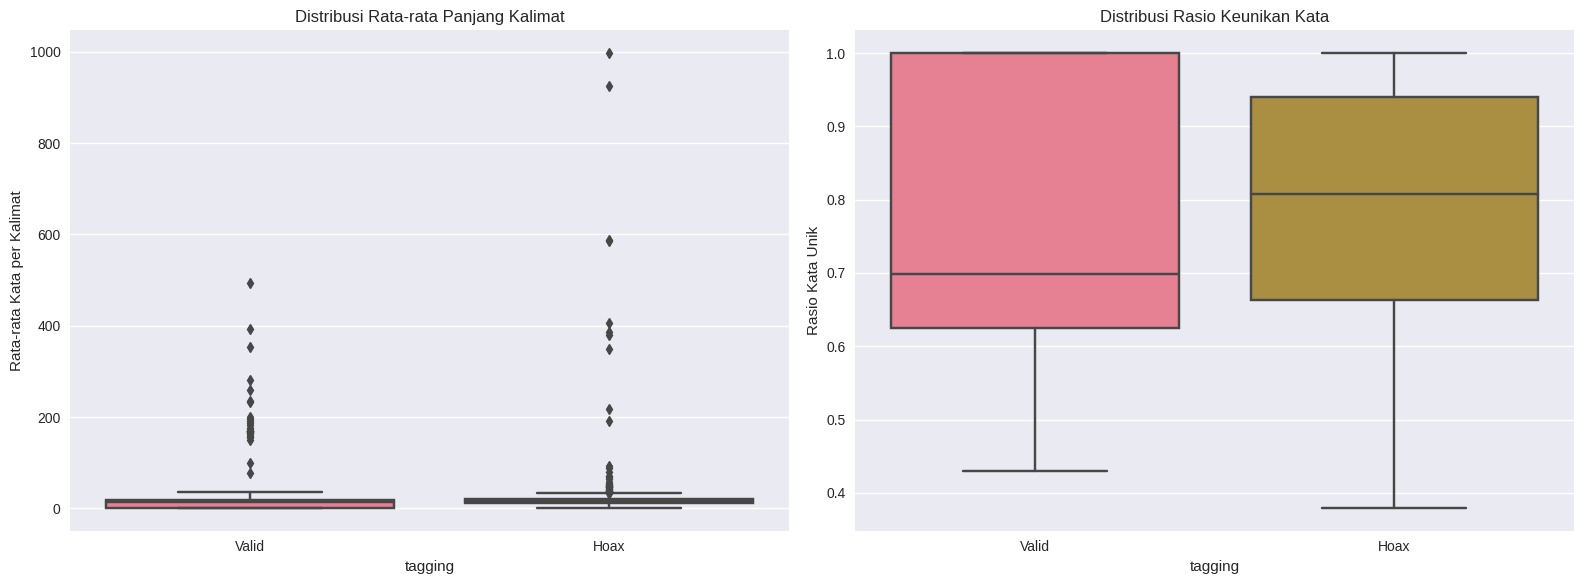

In [29]:
# Visualisasi kompleksitas bahasa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Average sentence length
sns.boxplot(data=df, x='tagging', y='avg_sentence_length', ax=axes[0])
axes[0].set_title('Distribusi Rata-rata Panjang Kalimat')
axes[0].set_ylabel('Rata-rata Kata per Kalimat')

# Unique word ratio
sns.boxplot(data=df, x='tagging', y='unique_word_ratio', ax=axes[1])
axes[1].set_title('Distribusi Rasio Keunikan Kata')
axes[1].set_ylabel('Rasio Kata Unik')

plt.tight_layout()
plt.show()

### Analisis Linguistik Lanjutan
- **Punctuation Patterns**: Pola penggunaan tanda baca dapat mengindikasikan gaya penulisan
- **Sentence Complexity**: Panjang rata-rata kalimat menunjukkan kompleksitas struktur bahasa
- **Vocabulary Diversity**: Rasio kata unik menunjukkan kekayaan vocabulary yang digunakan

### 12. Temporal and URL Pattern Analysis

In [30]:
# Analisis pola URL dan link
def extract_url_features(text):
    # Pattern untuk mendeteksi URL
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    urls = re.findall(url_pattern, text)

    # Pattern untuk mendeteksi mention media sosial
    social_patterns = {
        'twitter': r'@\w+',
        'hashtag': r'#\w+',
        'facebook': r'facebook\.com',
        'instagram': r'instagram\.com',
        'youtube': r'youtube\.com|youtu\.be'
    }

    features = {
        'url_count': len(urls),
        'has_url': len(urls) > 0,
    }

    for platform, pattern in social_patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        features[f'{platform}_count'] = len(matches)
        features[f'has_{platform}'] = len(matches) > 0

    return features

# Extract URL features
url_features = df['berita'].apply(extract_url_features)
url_df = pd.DataFrame(list(url_features))
url_df['tagging'] = df['tagging']

print("=== URL AND SOCIAL MEDIA PATTERN ANALYSIS ===")
print("\nURL Usage by Label:")
print(url_df.groupby('tagging')[['url_count', 'has_url']].agg(['mean', 'sum']))

print("\nSocial Media Mentions:")
social_cols = ['twitter_count', 'hashtag_count', 'facebook_count', 'instagram_count', 'youtube_count']
print(url_df.groupby('tagging')[social_cols].sum())

=== URL AND SOCIAL MEDIA PATTERN ANALYSIS ===

URL Usage by Label:
        url_count       has_url    
             mean sum      mean sum
tagging                            
Hoax     0.010909   6  0.009091   5
Valid    0.016364   9  0.007273   4

Social Media Mentions:
         twitter_count  hashtag_count  facebook_count  instagram_count  \
tagging                                                                  
Hoax                23             42               0                0   
Valid               24             59               0                0   

         youtube_count  
tagging                 
Hoax                 0  
Valid                0  


In [31]:
# Analisis pola waktu dan tanggal
def extract_time_patterns(text):
    # Pattern untuk mendeteksi tanggal dan waktu
    date_patterns = {
        'date_slash': r'\d{1,2}/\d{1,2}/\d{2,4}',  # 12/31/2023
        'date_dash': r'\d{1,2}-\d{1,2}-\d{2,4}',   # 12-31-2023
        'date_indo': r'\d{1,2}\s+(Januari|Februari|Maret|April|Mei|Juni|Juli|Agustus|September|Oktober|November|Desember)\s+\d{4}',
        'time_24': r'\d{1,2}:\d{2}',               # 14:30
        'year_mention': r'\b(19|20)\d{2}\b'        # 1999, 2023
    }

    features = {}
    for pattern_name, pattern in date_patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        features[f'{pattern_name}_count'] = len(matches)
        features[f'has_{pattern_name}'] = len(matches) > 0

    return features

# Extract time patterns
time_features = df['berita'].apply(extract_time_patterns)
time_df = pd.DataFrame(list(time_features))
time_df['tagging'] = df['tagging']

print("\n=== TIME AND DATE PATTERN ANALYSIS ===")
print("\nDate/Time Pattern Usage:")
time_cols = ['date_slash_count', 'date_dash_count', 'date_indo_count', 'time_24_count', 'year_mention_count']
print(time_df.groupby('tagging')[time_cols].mean())


=== TIME AND DATE PATTERN ANALYSIS ===

Date/Time Pattern Usage:
         date_slash_count  date_dash_count  date_indo_count  time_24_count  \
tagging                                                                      
Hoax             0.134545         0.001818         0.118182       0.010909   
Valid            0.318182         0.000000         0.263636       0.007273   

         year_mention_count  
tagging                      
Hoax               0.556364  
Valid              0.889091  


### Analisis Pola Temporal dan URL
- **URL Patterns**: Frekuensi penggunaan link dapat mengindikasikan kredibilitas atau spam
- **Social Media References**: Mention platform media sosial menunjukkan sumber atau penyebaran
- **Time Patterns**: Penggunaan tanggal dan waktu spesifik dapat menunjukkan faktualitas

### 13. Final Feature Engineering Recommendations

In [32]:
# Compile semua fitur yang telah dianalisis
final_features = {
    'basic_stats': ['text_length', 'word_count', 'sentence_count'],
    'content_features': ['suspicious_word_count', 'exclamation_count', 'question_count', 'uppercase_count'],
    'complexity_features': ['avg_sentence_length', 'unique_word_ratio', 'avg_word_length'],
    'pattern_features': ['number_count']
}

# Combine all features untuk final dataset
feature_columns = []
for category, features in final_features.items():
    feature_columns.extend(features)

# Create final feature matrix
final_df = df[['berita', 'tagging'] + feature_columns].copy()

print("=== FINAL FEATURE ENGINEERING SUMMARY ===")
print(f"\n📊 Total Features Extracted: {len(feature_columns)}")
print(f"📈 Dataset Shape: {final_df.shape}")

print("\n🎯 FEATURE CATEGORIES:")
for category, features in final_features.items():
    print(f"\n{category.upper()}:")
    for feature in features:
        if feature in final_df.columns:
            corr_with_target = abs(df[[feature, 'label_numeric']].corr().iloc[0,1])
            print(f"  - {feature}: correlation = {corr_with_target:.4f}")

# Export recommendations
print("\n\n🚀 MACHINE LEARNING PIPELINE RECOMMENDATIONS:")
print("\n1. 📋 DATA PREPROCESSING:")
print("   ✓ Text cleaning: remove special characters, normalize whitespace")
print("   ✓ Lowercasing and punctuation handling")
print("   ✓ Indonesian stopword removal")
print("   ✓ Handle missing values and duplicates")

print("\n2. 🔧 FEATURE ENGINEERING:")
print("   ✓ TF-IDF vectorization (1-3 grams)")
print("   ✓ Use extracted numerical features as additional columns")
print("   ✓ Consider word embeddings (Word2Vec, FastText for Indonesian)")
print("   ✓ Sentiment analysis scores")

print("\n3. 🤖 MODEL SELECTION:")
print("   ✓ Baseline: Naive Bayes with TF-IDF")
print("   ✓ Traditional ML: SVM, Random Forest, XGBoost")
print("   ✓ Deep Learning: LSTM, GRU with Indonesian word embeddings")
print("   ✓ Transformer-based: IndoBERT, multilingual BERT")

print("\n4. 📊 EVALUATION STRATEGY:")
print("   ✓ Stratified K-fold cross-validation")
print("   ✓ Metrics: Accuracy, Precision, Recall, F1-score, AUC-ROC")
print("   ✓ Confusion matrix analysis")
print("   ✓ Feature importance analysis")
print("   ✓ Error analysis on misclassified samples")

print("\n5. 🎯 DEPLOYMENT CONSIDERATIONS:")
print("   ✓ Model size vs accuracy trade-off")
print("   ✓ Inference speed requirements")
print("   ✓ Regular model updates with new data")
print("   ✓ Monitoring for data drift")

# Save processed dataset info
print(f"\n💾 PROCESSED DATA READY FOR ML:")
print(f"   - Shape: {final_df.shape}")
print(f"   - Features: {len(feature_columns)} numerical + text")
print(f"   - Classes: {final_df['tagging'].nunique()} (balanced: {final_df['tagging'].value_counts().min()/final_df['tagging'].value_counts().max():.2f})")
print(f"   - Ready for train/validation/test split")

=== FINAL FEATURE ENGINEERING SUMMARY ===

📊 Total Features Extracted: 11
📈 Dataset Shape: (1100, 13)

🎯 FEATURE CATEGORIES:

BASIC_STATS:
  - text_length: correlation = 0.1194
  - word_count: correlation = 0.1140
  - sentence_count: correlation = 0.1223

CONTENT_FEATURES:
  - suspicious_word_count: correlation = 0.0250
  - exclamation_count: correlation = 0.1630
  - question_count: correlation = 0.0123
  - uppercase_count: correlation = 0.0834

COMPLEXITY_FEATURES:
  - avg_sentence_length: correlation = 0.0434
  - unique_word_ratio: correlation = 0.1002
  - avg_word_length: correlation = 0.4043

PATTERN_FEATURES:
  - number_count: correlation = 0.0315


🚀 MACHINE LEARNING PIPELINE RECOMMENDATIONS:

1. 📋 DATA PREPROCESSING:
   ✓ Text cleaning: remove special characters, normalize whitespace
   ✓ Lowercasing and punctuation handling
   ✓ Indonesian stopword removal
   ✓ Handle missing values and duplicates

2. 🔧 FEATURE ENGINEERING:
   ✓ TF-IDF vectorization (1-3 grams)
   ✓ Use extract

In [33]:
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=SEED, stratify=df[LABEL_COL])
train_df, val_df  = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df[LABEL_COL])

label2id = {l:i for i,l in enumerate(sorted(df[LABEL_COL].unique()))}
id2label = {i:l for l,i in label2id.items()}

print("Labels:", label2id)
for name, part in [("train", train_df), ("val", val_df), ("test", test_df)]:
    print(f"{name}: {part.shape}, label dist =\n", part[LABEL_COL].value_counts(normalize=True))

Labels: {'Hoax': 0, 'Valid': 1}
train: (704, 13), label dist =
 tagging
Hoax     0.5
Valid    0.5
Name: proportion, dtype: float64
val: (176, 13), label dist =
 tagging
Hoax     0.5
Valid    0.5
Name: proportion, dtype: float64
test: (220, 13), label dist =
 tagging
Hoax     0.5
Valid    0.5
Name: proportion, dtype: float64


# Hugging Face Datasets for Transformers

In [34]:
def to_hf(df_):
    return Dataset.from_pandas(pd.DataFrame({
        "text": df_[TEXT_COL].astype(str).tolist(),
        "label": df_[LABEL_COL].map(label2id).astype(int).tolist()
    }))

hf = DatasetDict({
    "train": to_hf(train_df),
    "validation": to_hf(val_df),
    "test": to_hf(test_df)
})
hf

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 704
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 176
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 220
    })
})

In [35]:
def build_tokenize_fn(model_name, max_length=512):
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    def _tok(examples):
        return tok(examples["text"], truncation=True, max_length=max_length)
    return tok, _tok

In [36]:
metric_acc = evaluate.load("accuracy")
metric_f1m = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": metric_f1m.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

def train_one_model(model_name, output_dir, num_labels, epochs=2, lr=5e-5, batch_size=16):
    tokenizer, tokenize_fn = build_tokenize_fn(model_name)
    tokenized = hf.map(tokenize_fn, batched=True, remove_columns=["text"])
    collator = DataCollatorWithPadding(tokenizer=tokenizer)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)
    args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        seed=SEED,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    # Return trainer + tokenizer to use for predictions
    return trainer, tokenizer

In [37]:
trainers = []
tokenizers = []
for i, mname in enumerate(id_models):
    print(f"\n==== Training {i+1}/{len(id_models)}: {mname} ====")
    tr, tok = train_one_model(mname, output_dir=f"./model_{i}_{mname.replace('/', '_')}", num_labels=len(label2id), epochs=2, lr=2e-5, batch_size=16)
    trainers.append(tr); tokenizers.append(tok)


==== Training 1/3: indobenchmark/indobert-base-p1 ====


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/704 [00:00<?, ? examples/s]

Map:   0%|          | 0/176 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.449405,0.744318,0.733790
2,0.415300,0.405506,0.767045,0.762998



==== Training 2/3: distilbert-base-multilingual-cased ====


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/704 [00:00<?, ? examples/s]

Map:   0%|          | 0/176 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.470869,0.755682,0.743066
2,0.533300,0.438599,0.732955,0.723224



==== Training 3/3: bert-base-multilingual-uncased ====


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Map:   0%|          | 0/704 [00:00<?, ? examples/s]

Map:   0%|          | 0/176 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.474155,0.761364,0.757576
2,0.506300,0.458102,0.738636,0.735874


In [38]:
def predict_logits(trainer, tokenizer, texts, batch_size=16, max_length=512):
    all_logits = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, max_length=max_length, return_tensors="pt", padding=True)
        enc = {k: v.to(trainer.model.device) for k,v in enc.items()}
        with torch.no_grad():
            outputs = trainer.model(**enc)
        all_logits.append(outputs.logits.detach().cpu().numpy())
    return np.vstack(all_logits)

# Collect logits on validation + test for each model
val_texts = val_df[TEXT_COL].tolist()
test_texts = test_df[TEXT_COL].tolist()
y_val = val_df[LABEL_COL].map(label2id).values
y_test = test_df[LABEL_COL].map(label2id).values

val_logits_list = []
test_logits_list = []
for tr, tok in zip(trainers, tokenizers):
    val_logits_list.append(predict_logits(tr, tok, val_texts))
    test_logits_list.append(predict_logits(tr, tok, test_texts))

# Average logits
val_logits_avg = np.mean(val_logits_list, axis=0)
test_logits_avg = np.mean(test_logits_list, axis=0)

val_preds = val_logits_avg.argmax(axis=1)
test_preds = test_logits_avg.argmax(axis=1)

print("=== ENSEMBLE (AVERAGE LOGITS) ===")
print("Val Acc:", accuracy_score(y_val, val_preds), "Val F1:", f1_score(y_val, val_preds, average="macro"))
print("Test Acc:", accuracy_score(y_test, test_preds), "Test F1:", f1_score(y_test, test_preds, average="macro"))
print(classification_report(y_test, test_preds, target_names=[id2label[i] for i in range(len(id2label))]))

=== ENSEMBLE (AVERAGE LOGITS) ===
Val Acc: 0.75 Val F1: 0.7425189519882963
Test Acc: 0.8318181818181818 Test F1: 0.8302716904022185
              precision    recall  f1-score   support

        Hoax       0.91      0.74      0.81       110
       Valid       0.78      0.93      0.85       110

    accuracy                           0.83       220
   macro avg       0.84      0.83      0.83       220
weighted avg       0.84      0.83      0.83       220

